In [1]:
from IPython.core.display import display, HTML; display(HTML("<style>.container{width:90% !important;}</style>")) 

# Personality and preferences for movies analysis

Data come from: https://www.kaggle.com/datasets/arslanali4343/top-personality-dataset

## The purpose of research: 

The aim of the study is to create an algorithm that predict the level of satisfaction with watching movies from the suggested list based on the personality traits of the Big Five Personality model, the method of assigning a preferred list of films and movie preferences.


## Loading required libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA

## Loading data and checking features

Data are in two sets:
1. First set contains information about:
  - personality (based on TIPI questionnaire), 
  - way to prepare recommendation movies lists,
  - recommandion list and rating of movies from recommendation,
  - information if user consider recommendation as personalized,
  - level of satisfaction form watching movies.
2. Second set contains list of movies and their ratings which users makes at the beginning. The user have to rate at least 15 movies. 

### 1. Data about personality and predicted movies

In [3]:
df_person = pd.read_csv("2018-personality-data.csv")

In [4]:
df_person.head(3)

,userid,openness,agreeableness,emotional_stability,conscientiousness,extraversion,assigned metric,assigned condition,movie_1,predicted_rating_1,...,movie_9,predicted_rating_9,movie_10,predicted_rating_10,movie_11,predicted_rating_11,movie_12,predicted_rating_12,is_personalized,enjoy_watching
0,8e7cebf9a234c064b75016249f2ac65e,5.0,2.0,3.0,2.5,6.5,serendipity,high,77658,4.410466,...,120138,4.244817,121372,4.396004,127152,4.120456,95311,4.053847,4,4
1,77c7d756a093150d4377720abeaeef76,7.0,4.0,6.0,5.5,4.0,all,default,94959,4.207280,...,56782,4.019599,5618,3.963953,969,4.174188,1232,4.334877,2,3
2,b7e8a92987a530cc368719a0e60e26a3,4.0,3.0,4.5,2.0,2.5,serendipity,medium,110501,4.868064,...,2288,4.823212,3307,4.676756,1172,4.649281,1212,4.744990,2,2


In [5]:
df_person.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1834 entries, 0 to 1833
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   userid                1834 non-null   object 
 1    openness             1834 non-null   float64
 2    agreeableness        1834 non-null   float64
 3    emotional_stability  1834 non-null   float64
 4    conscientiousness    1834 non-null   float64
 5    extraversion         1834 non-null   float64
 6    assigned metric      1834 non-null   object 
 7    assigned condition   1834 non-null   object 
 8    movie_1              1834 non-null   int64  
 9    predicted_rating_1   1834 non-null   float64
 10   movie_2              1834 non-null   int64  
 11   predicted_rating_2   1834 non-null   float64
 12   movie_3              1834 non-null   int64  
 13   predicted_rating_3   1834 non-null   float64
 14   movie_4              1834 non-null   int64  
 15   predicted_rating_4  

In [6]:
df_person["userid"].nunique()

1820

Data summary:
- there are no missing data in set, 
- 14 rows are not unique (1834 vs. 1820 unique), they make unnecessary noise, so they need to be deleted,
- names contain spaces at the beginning (besides "userid"), so they will be edited.

In [7]:
df_person.drop_duplicates(keep='first', inplace=True, ignore_index=True)

In [8]:
df_person.columns = df_person.columns.str.replace(' ', '')
df_person.rename({'assignedmetric': 'assigned_metric', 'assignedcondition': 'assigned_condition'}, inplace=True, axis='columns')

### 2. Data about ratings movies

In [9]:
df_rating = pd.read_csv("2018_ratings.csv")

In [10]:
df_rating.head(3)

,useri,movie_id,rating,tstamp
0,8e7cebf9a234c064b75016249f2ac65e,1,5.0,2001-09-10 17:19:56
1,8e7cebf9a234c064b75016249f2ac65e,2,4.0,2001-09-28 11:34:55
2,8e7cebf9a234c064b75016249f2ac65e,3,4.0,2001-09-28 11:42:50


In [11]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028751 entries, 0 to 1028750
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   useri      1028751 non-null  object 
 1    movie_id  1028751 non-null  int64  
 2    rating    1028751 non-null  float64
 3    tstamp    1028751 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 31.4+ MB


Data summary:
- there are no missing data in set, 
- names contain spaces at the beginning (besides "useri"), so they will be edited,
- name "useri" will be renamed to "userid".

In [12]:
df_rating.columns = df_rating.columns.str.replace(' ', '')

In [13]:
df_rating.rename({'useri': 'userid'}, inplace=True, axis='columns')

### 3. Data linking

In [14]:
df=pd.merge(df_rating, df_person, on=('userid'))
df.head()

,userid,movie_id,rating,tstamp,openness,agreeableness,emotional_stability,conscientiousness,extraversion,assigned_metric,...,movie_9,predicted_rating_9,movie_10,predicted_rating_10,movie_11,predicted_rating_11,movie_12,predicted_rating_12,is_personalized,enjoy_watching
0,8e7cebf9a234c064b75016249f2ac65e,1,5.0,2001-09-10 17:19:56,5.0,2.0,3.0,2.5,6.5,serendipity,...,120138,4.244817,121372,4.396004,127152,4.120456,95311,4.053847,4,4
1,8e7cebf9a234c064b75016249f2ac65e,2,4.0,2001-09-28 11:34:55,5.0,2.0,3.0,2.5,6.5,serendipity,...,120138,4.244817,121372,4.396004,127152,4.120456,95311,4.053847,4,4
2,8e7cebf9a234c064b75016249f2ac65e,3,4.0,2001-09-28 11:42:50,5.0,2.0,3.0,2.5,6.5,serendipity,...,120138,4.244817,121372,4.396004,127152,4.120456,95311,4.053847,4,4
3,8e7cebf9a234c064b75016249f2ac65e,5,5.0,2001-09-28 11:27:30,5.0,2.0,3.0,2.5,6.5,serendipity,...,120138,4.244817,121372,4.396004,127152,4.120456,95311,4.053847,4,4
4,8e7cebf9a234c064b75016249f2ac65e,6,4.0,2002-01-07 18:12:02,5.0,2.0,3.0,2.5,6.5,serendipity,...,120138,4.244817,121372,4.396004,127152,4.120456,95311,4.053847,4,4


### 4.  Features modifications

Based on knowledge from the research the next features are chosen for further analysis:

In [15]:
for i in range(1,13):
    df.drop([f"movie_{i}"], axis=1, inplace=True)
df.drop(["userid", "movie_id", "tstamp", "assigned_condition"], axis=1, inplace=True)
df.columns

Index(['rating', 'openness', 'agreeableness', 'emotional_stability',
       'conscientiousness', 'extraversion', 'assigned_metric',
       'predicted_rating_1', 'predicted_rating_2', 'predicted_rating_3',
       'predicted_rating_4', 'predicted_rating_5', 'predicted_rating_6',
       'predicted_rating_7', 'predicted_rating_8', 'predicted_rating_9',
       'predicted_rating_10', 'predicted_rating_11', 'predicted_rating_12',
       'is_personalized', 'enjoy_watching'],
      dtype='object')

Feature "assigned_metric" is categorical with strings, so will be encode to numbers. 

In [16]:
le = LabelEncoder()
df.assigned_metric = le.fit_transform(df.assigned_metric)

In [17]:
df.head()

,rating,openness,agreeableness,emotional_stability,conscientiousness,extraversion,assigned_metric,predicted_rating_1,predicted_rating_2,predicted_rating_3,...,predicted_rating_5,predicted_rating_6,predicted_rating_7,predicted_rating_8,predicted_rating_9,predicted_rating_10,predicted_rating_11,predicted_rating_12,is_personalized,enjoy_watching
0,5.0,5.0,2.0,3.0,2.5,6.5,3,4.410466,4.271995,4.611922,...,4.147292,4.098206,4.064843,4.1491,4.244817,4.396004,4.120456,4.053847,4,4
1,4.0,5.0,2.0,3.0,2.5,6.5,3,4.410466,4.271995,4.611922,...,4.147292,4.098206,4.064843,4.1491,4.244817,4.396004,4.120456,4.053847,4,4
2,4.0,5.0,2.0,3.0,2.5,6.5,3,4.410466,4.271995,4.611922,...,4.147292,4.098206,4.064843,4.1491,4.244817,4.396004,4.120456,4.053847,4,4
3,5.0,5.0,2.0,3.0,2.5,6.5,3,4.410466,4.271995,4.611922,...,4.147292,4.098206,4.064843,4.1491,4.244817,4.396004,4.120456,4.053847,4,4
4,4.0,5.0,2.0,3.0,2.5,6.5,3,4.410466,4.271995,4.611922,...,4.147292,4.098206,4.064843,4.1491,4.244817,4.396004,4.120456,4.053847,4,4


### 5. Target variable

In [18]:
df["enjoy_watching"].value_counts()

4    429164
3    250367
2    169220
5    148732
1     32632
Name: enjoy_watching, dtype: int64

"Enjoy_watching" describes user's responses if they like recommended movies from Strongly Disagree to Strongly Agree. Looking at the results, more than half of the users responded positively to the recommendations. That's why will be created new varaible "enjoy_watching_new" to emphasize this binary split. The responses 4-5 will be assigned to 1, and 0-3 to 0.

In [19]:
def check_ejnoy(x):
    if x >= 4:
        return 1
    else:
        return 0

In [20]:
df["enjoy_watching_new"] = df["enjoy_watching"].apply(check_ejnoy)

In [21]:
df.head()

,rating,openness,agreeableness,emotional_stability,conscientiousness,extraversion,assigned_metric,predicted_rating_1,predicted_rating_2,predicted_rating_3,...,predicted_rating_6,predicted_rating_7,predicted_rating_8,predicted_rating_9,predicted_rating_10,predicted_rating_11,predicted_rating_12,is_personalized,enjoy_watching,enjoy_watching_new
0,5.0,5.0,2.0,3.0,2.5,6.5,3,4.410466,4.271995,4.611922,...,4.098206,4.064843,4.1491,4.244817,4.396004,4.120456,4.053847,4,4,1
1,4.0,5.0,2.0,3.0,2.5,6.5,3,4.410466,4.271995,4.611922,...,4.098206,4.064843,4.1491,4.244817,4.396004,4.120456,4.053847,4,4,1
2,4.0,5.0,2.0,3.0,2.5,6.5,3,4.410466,4.271995,4.611922,...,4.098206,4.064843,4.1491,4.244817,4.396004,4.120456,4.053847,4,4,1
3,5.0,5.0,2.0,3.0,2.5,6.5,3,4.410466,4.271995,4.611922,...,4.098206,4.064843,4.1491,4.244817,4.396004,4.120456,4.053847,4,4,1
4,4.0,5.0,2.0,3.0,2.5,6.5,3,4.410466,4.271995,4.611922,...,4.098206,4.064843,4.1491,4.244817,4.396004,4.120456,4.053847,4,4,1


In [22]:
df.drop(["enjoy_watching"], axis=1, inplace=True)

In [23]:
df["enjoy_watching_new"].value_counts()

1    577896
0    452219
Name: enjoy_watching_new, dtype: int64

In [24]:
df.head()

,rating,openness,agreeableness,emotional_stability,conscientiousness,extraversion,assigned_metric,predicted_rating_1,predicted_rating_2,predicted_rating_3,...,predicted_rating_5,predicted_rating_6,predicted_rating_7,predicted_rating_8,predicted_rating_9,predicted_rating_10,predicted_rating_11,predicted_rating_12,is_personalized,enjoy_watching_new
0,5.0,5.0,2.0,3.0,2.5,6.5,3,4.410466,4.271995,4.611922,...,4.147292,4.098206,4.064843,4.1491,4.244817,4.396004,4.120456,4.053847,4,1
1,4.0,5.0,2.0,3.0,2.5,6.5,3,4.410466,4.271995,4.611922,...,4.147292,4.098206,4.064843,4.1491,4.244817,4.396004,4.120456,4.053847,4,1
2,4.0,5.0,2.0,3.0,2.5,6.5,3,4.410466,4.271995,4.611922,...,4.147292,4.098206,4.064843,4.1491,4.244817,4.396004,4.120456,4.053847,4,1
3,5.0,5.0,2.0,3.0,2.5,6.5,3,4.410466,4.271995,4.611922,...,4.147292,4.098206,4.064843,4.1491,4.244817,4.396004,4.120456,4.053847,4,1
4,4.0,5.0,2.0,3.0,2.5,6.5,3,4.410466,4.271995,4.611922,...,4.147292,4.098206,4.064843,4.1491,4.244817,4.396004,4.120456,4.053847,4,1


### 6. Variables describe

In [25]:
round(df.describe(), 3)

,rating,openness,agreeableness,emotional_stability,conscientiousness,extraversion,assigned_metric,predicted_rating_1,predicted_rating_2,predicted_rating_3,...,predicted_rating_5,predicted_rating_6,predicted_rating_7,predicted_rating_8,predicted_rating_9,predicted_rating_10,predicted_rating_11,predicted_rating_12,is_personalized,enjoy_watching_new
count,1030115.000,1030115.000,1030115.000,1030115.000,1030115.000,1030115.000,1030115.00,1030115.000,1030115.000,1030115.000,...,1030115.000,1030115.000,1030115.000,1030115.000,1030115.000,1030115.000,1030115.000,1030115.000,1030115.000,1030115.000
mean,3.369,5.342,4.195,4.595,4.708,3.383,1.79,4.327,4.294,4.286,...,4.273,4.269,4.257,4.258,4.278,4.281,4.272,4.263,3.028,0.561
std,1.011,1.068,1.194,1.391,1.287,1.450,0.99,0.406,0.408,0.423,...,0.419,0.392,0.394,0.393,0.415,0.411,0.414,0.388,1.091,0.496
min,0.500,1.000,1.000,1.000,1.000,1.000,0.00,2.511,2.423,2.334,...,2.606,2.379,2.401,2.321,2.483,2.800,2.376,2.313,1.000,0.000
25%,3.000,4.500,3.500,3.500,4.000,2.000,1.00,4.042,4.031,4.015,...,4.007,4.006,3.981,3.995,3.999,3.997,4.000,3.988,2.000,0.000
50%,3.500,5.500,4.000,4.500,4.500,3.000,2.00,4.313,4.279,4.262,...,4.256,4.253,4.241,4.246,4.260,4.267,4.244,4.259,3.000,1.000
75%,4.000,6.000,5.000,5.500,5.500,4.500,3.00,4.572,4.517,4.554,...,4.527,4.519,4.505,4.506,4.516,4.518,4.519,4.511,4.000,1.000
max,5.000,7.000,7.000,7.000,7.000,7.000,3.00,6.564,6.586,6.438,...,6.371,6.064,6.331,6.289,6.607,7.345,6.530,6.575,5.000,1.000


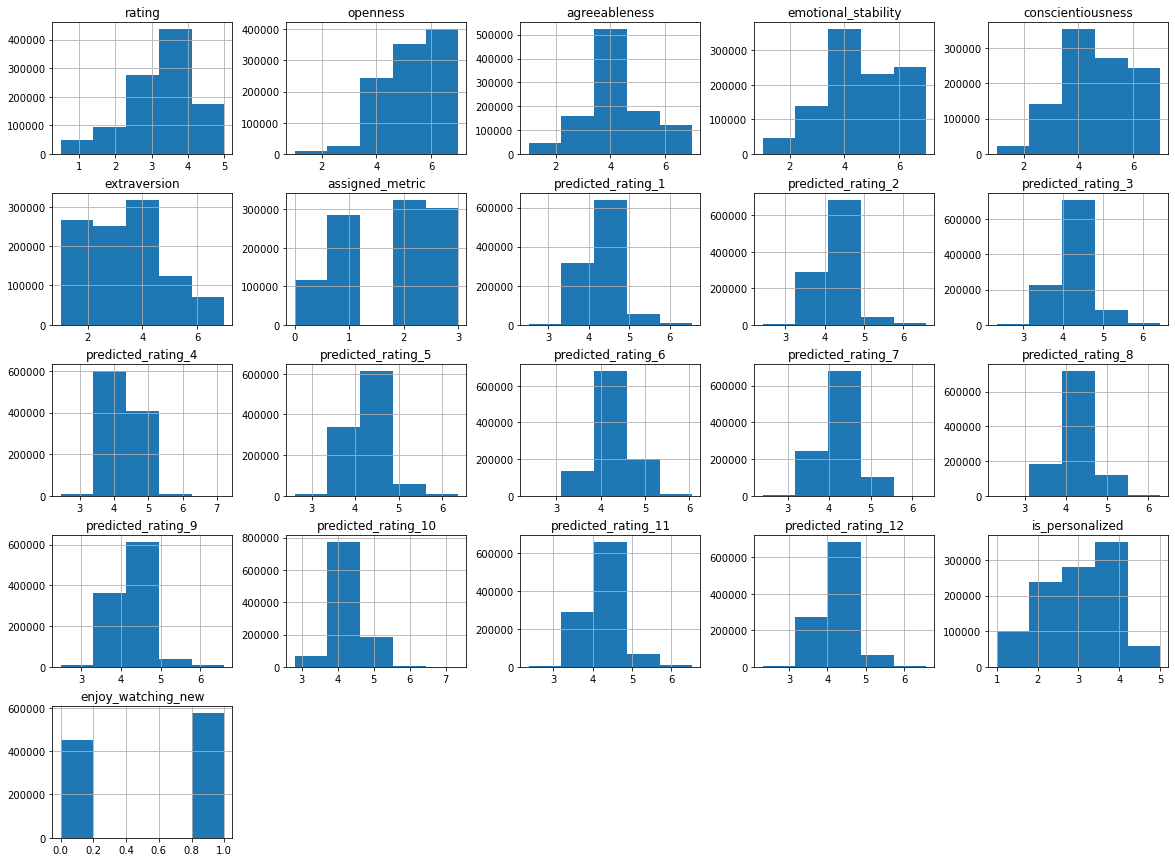

In [26]:
df.hist(bins=5, figsize=(20,15))
plt.show()

### 7. Test for normality of distribution

H0: sample comes from a normal distribution

H1: sample does not come from a normal distribution

In [27]:
list_col=list(df.columns)

In [28]:
del list_col [6]
list_col

['rating',
 'openness',
 'agreeableness',
 'emotional_stability',
 'conscientiousness',
 'extraversion',
 'predicted_rating_1',
 'predicted_rating_2',
 'predicted_rating_3',
 'predicted_rating_4',
 'predicted_rating_5',
 'predicted_rating_6',
 'predicted_rating_7',
 'predicted_rating_8',
 'predicted_rating_9',
 'predicted_rating_10',
 'predicted_rating_11',
 'predicted_rating_12',
 'is_personalized',
 'enjoy_watching_new']

In [29]:
len(list_col)

20

In [30]:
for i in range(len(list_col)):
    normaltest = stats.normaltest(df[list_col[i]])
    p_value = np.round(normaltest,3)[1]
    if p_value < 0.05:
        print(f"For {list_col[i]}: p-value = {np.round(normaltest,3)[1]}." 
              "I reject the null hypothesis. The variable DOES NOT COME from the normal distribution.")
    else:
        print(f"For {list_col[i]}: p-value = {np.round(normaltest,3)[1]}." 
              "No reason to reject the null hypothesis. The variable COMES from the normal distribution.")

For rating: p-value = 0.0.I reject the null hypothesis. The variable DOES NOT COME from the normal distribution.
For openness: p-value = 0.0.I reject the null hypothesis. The variable DOES NOT COME from the normal distribution.
For agreeableness: p-value = 0.0.I reject the null hypothesis. The variable DOES NOT COME from the normal distribution.
For emotional_stability: p-value = 0.0.I reject the null hypothesis. The variable DOES NOT COME from the normal distribution.
For conscientiousness: p-value = 0.0.I reject the null hypothesis. The variable DOES NOT COME from the normal distribution.
For extraversion: p-value = 0.0.I reject the null hypothesis. The variable DOES NOT COME from the normal distribution.
For predicted_rating_1: p-value = 0.0.I reject the null hypothesis. The variable DOES NOT COME from the normal distribution.
For predicted_rating_2: p-value = 0.0.I reject the null hypothesis. The variable DOES NOT COME from the normal distribution.
For predicted_rating_3: p-value =

None of variables come from the normal distribution. 

### 8. Correlation checking

Pearson's correlaction can not be used because samples do not come from normal distrbution, so it is used Spearman's rank correlation. 

H0: target variable is correlated with target variable

H1: target variable is not correlated with target variable

In [31]:
correlation_matrix = pd.DataFrame(np.abs(stats.spearmanr(df)[0]), columns = df.columns, index = df.columns)
correlation_matrix

,rating,openness,agreeableness,emotional_stability,conscientiousness,extraversion,assigned_metric,predicted_rating_1,predicted_rating_2,predicted_rating_3,...,predicted_rating_5,predicted_rating_6,predicted_rating_7,predicted_rating_8,predicted_rating_9,predicted_rating_10,predicted_rating_11,predicted_rating_12,is_personalized,enjoy_watching_new
rating,1.000000,0.016872,0.051992,0.031325,0.014818,0.047844,0.016510,0.191409,0.189009,0.199471,...,0.200587,0.189288,0.199539,0.206140,0.199305,0.193541,0.200398,0.201456,0.051381,0.069813
openness,0.016872,1.000000,0.044894,0.037383,0.008142,0.260400,0.028425,0.108380,0.096740,0.087181,...,0.087137,0.092560,0.087927,0.090347,0.085156,0.093534,0.078707,0.113171,0.023520,0.058633
agreeableness,0.051992,0.044894,1.000000,0.227291,0.107587,0.091691,0.079396,0.107961,0.135241,0.113993,...,0.093591,0.091744,0.063561,0.099058,0.112908,0.101107,0.101892,0.137739,0.048699,0.056664
emotional_stability,0.031325,0.037383,0.227291,1.000000,0.318618,0.045881,0.043777,0.010222,0.049498,0.009087,...,0.011743,0.000423,0.019279,0.003518,0.008293,0.008175,0.009721,0.019808,0.058662,0.003563
conscientiousness,0.014818,0.008142,0.107587,0.318618,1.000000,0.008772,0.038703,0.041631,0.008597,0.052646,...,0.043354,0.020102,0.063504,0.055271,0.030087,0.059285,0.064311,0.014918,0.001485,0.048156
extraversion,0.047844,0.260400,0.091691,0.045881,0.008772,1.000000,0.028794,0.029764,0.028168,0.062023,...,0.023000,0.059637,0.013603,0.029762,0.051825,0.040040,0.029927,0.037878,0.024042,0.039293
assigned_metric,0.016510,0.028425,0.079396,0.043777,0.038703,0.028794,1.000000,0.210551,0.153904,0.111242,...,0.107996,0.156988,0.129660,0.150666,0.106642,0.088838,0.109451,0.060007,0.039159,0.030583
predicted_rating_1,0.191409,0.108380,0.107961,0.010222,0.041631,0.029764,0.210551,1.000000,0.867236,0.823359,...,0.828733,0.826725,0.826012,0.843615,0.819568,0.803164,0.811855,0.811981,0.065722,0.077244
predicted_rating_2,0.189009,0.096740,0.135241,0.049498,0.008597,0.028168,0.153904,0.867236,1.000000,0.832208,...,0.841371,0.824601,0.825605,0.834786,0.812688,0.814261,0.824724,0.820641,0.046118,0.030779
predicted_rating_3,0.199471,0.087181,0.113993,0.009087,0.052646,0.062023,0.111242,0.823359,0.832208,1.000000,...,0.838334,0.824065,0.836118,0.836349,0.822905,0.810442,0.828665,0.815841,0.056362,0.053701


In [35]:
correlation_matrix.drop('enjoy_watching_new', axis = 0, inplace = True)
correlation_matrix.reset_index(inplace=True)

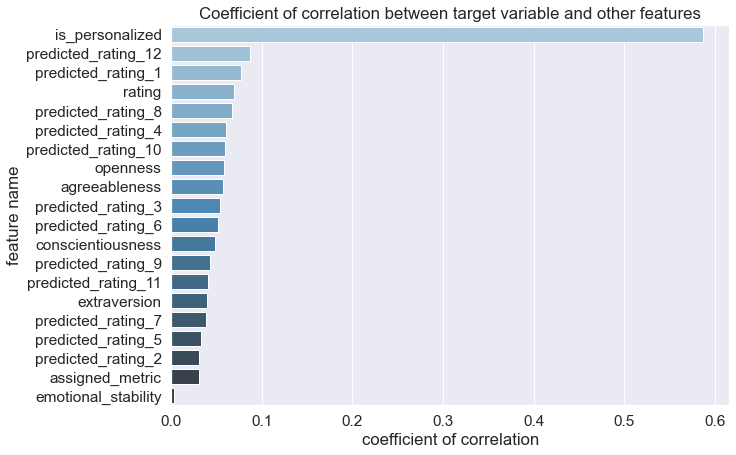

In [36]:
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)
sns.barplot(data = correlation_matrix.sort_values('enjoy_watching_new', ascending=False), x = 'enjoy_watching_new', y = "index", palette = 'Blues_d').set(title = 'Coefficient of correlation between target variable and other features', xlabel = 'coefficient of correlation', ylabel = 'feature name')
plt.show()

In [52]:
stat, p = stats.spearmanr(df)
for i in range(0,len(df.columns)-1):
    print(f"For enjoy_watching_new and {df.columns[i]}: statistic = {np.round(stat, 3)[i,20]}, p-value = {np.round(p, 3)[i,20]}")

For enjoy_watching_new and rating: statistic = 0.07, p-value = 0.0
For enjoy_watching_new and openness: statistic = 0.059, p-value = 0.0
For enjoy_watching_new and agreeableness: statistic = 0.057, p-value = 0.0
For enjoy_watching_new and emotional_stability: statistic = 0.004, p-value = 0.0
For enjoy_watching_new and conscientiousness: statistic = -0.048, p-value = 0.0
For enjoy_watching_new and extraversion: statistic = 0.039, p-value = 0.0
For enjoy_watching_new and assigned_metric: statistic = -0.031, p-value = 0.0
For enjoy_watching_new and predicted_rating_1: statistic = 0.077, p-value = 0.0
For enjoy_watching_new and predicted_rating_2: statistic = 0.031, p-value = 0.0
For enjoy_watching_new and predicted_rating_3: statistic = 0.054, p-value = 0.0
For enjoy_watching_new and predicted_rating_4: statistic = 0.06, p-value = 0.0
For enjoy_watching_new and predicted_rating_5: statistic = 0.033, p-value = 0.0
For enjoy_watching_new and predicted_rating_6: statistic = 0.051, p-value = 

All features are correlated with "enjoy_watching_new", but only "is_personalized" is strongly correlated, the rest of the correlation does not exceed the level 0.1, what mean a slight correlation.

## Machine learning model

### 1. Prepare data to machine learning

In [25]:
X = df.drop("enjoy_watching_new", axis=1)
y = df.enjoy_watching_new

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 2. Base models

The data will first be checked against default models.

To improve the work, will be used a prepared function to create a model and its evaluation.

In [43]:
def model_and_evaluate(model, X_train, y_train, X_test, y_test):
    
    model.fit(X_train, y_train)
    y_model = model.predict(X_test)
    accuracy = round(accuracy_score(y_test, model.predict(X_test)), 3)
    precision = round(precision_score(y_test, model.predict(X_test), average="binary"), 3)
    recall = round(recall_score(y_test, model.predict(X_test), average="binary"), 3)
    f1 = round(f1_score(y_test, model.predict(X_test), average="binary"),3)
    
    return print(f" accuracy = {accuracy}, precision = {precision}, recall = {recall} , f1 = {f1}")

For the model fitting, I will try out the following:
1. Logistic Regression
2. Decision Tree
3. AdaBoost
4. GradientBoosting

In [37]:
models = [LogisticRegression(max_iter=10000), DecisionTreeClassifier(),
          AdaBoostClassifier(), GradientBoostingClassifier()]

for model in models:
    print(model)
    print(model_and_evaluate(model, X_train, y_train, X_test, y_test))

LogisticRegression(max_iter=10000)
 accuracy = 0.786, precision = 0.789, recall = 0.844 , f1 = 0.816.
None
DecisionTreeClassifier()
 accuracy = 1.0, precision = 1.0, recall = 1.0 , f1 = 1.0.
None
AdaBoostClassifier()
 accuracy = 0.817, precision = 0.83, recall = 0.846 , f1 = 0.838.
None
GradientBoostingClassifier()
 accuracy = 0.896, precision = 0.894, recall = 0.924 , f1 = 0.909.
None


The base models gave high scores for the rates. But taking into account the correlation with the enjoy_watching_new variable, the PCA method will be performed to reduce dimensions of the models.

### 3.PCA

In [29]:
pca = PCA()
pca.fit(X_train)

PCA()

In [35]:
pca.components_.shape

(20, 20)

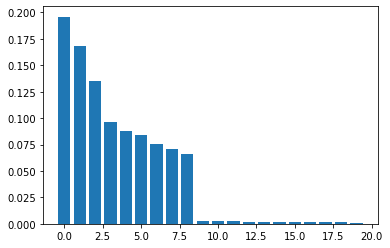

In [36]:
plt.bar(range(pca.n_components_),pca.explained_variance_ratio_)
plt.show()

In [30]:
pca = PCA(n_components=8)
pca.fit(X_train)

PCA(n_components=8)

In [31]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

The analysis will be performed for Decision Tree and Gradient Boosting, as these two models have lately the highest rates.

In [44]:
models = [DecisionTreeClassifier(), GradientBoostingClassifier()]

for model in models:
    print(model)
    print(model_and_evaluate(model, X_train_pca, y_train, X_test_pca, y_test))

DecisionTreeClassifier()
 accuracy = 1.0, precision = 1.0, recall = 1.0 , f1 = 1.0
None
GradientBoostingClassifier()
 accuracy = 0.86, precision = 0.856, recall = 0.901 , f1 = 0.878
None


The Grid Search technique will be used to determine the best parameters for Decision Tree. The default model seems to be overfitted.

### 4. Selection model and hyperparamets
The function for building and evaluating the model will be created.

In [28]:
def optimize_and_evaluate_grid(model, param_distr, X_train, y_train, X_test, y_test):
    
    optimizer = GridSearchCV(model, 
                         param_distr, 
                         cv=10, 
                         scoring="accuracy",
                         n_jobs=-1)
    optimizer.fit(X_train, y_train)

    best_params = optimizer.best_params_
    accuracy = round(accuracy_score(y_test, optimizer.best_estimator_.predict(X_test)), 3)
    precision = round(precision_score(y_test, optimizer.best_estimator_.predict(X_test), average="binary"), 3)
    recall = round(recall_score(y_test, optimizer.best_estimator_.predict(X_test), average="binary"), 3)
    f1 = round(f1_score(y_test, optimizer.best_estimator_.predict(X_test), average="binary"),3)
    
    return print(f" accuracy = {accuracy}, precision = {precision}, recall = {recall} , f1 = {f1}, best parameters: {best_params}")

In [33]:
dtc = DecisionTreeClassifier()
param_dtc=[{"criterion":["gini", "entropy"],
     "max_depth":[10, 15],
     "min_samples_leaf":[2, 5]}]
dtc_gr_pca = optimize_and_evaluate_grid(dtc, param_dtc, X_train_pca, y_train, X_test_pca, y_test)
print(dtc_gr_pca)

 accuracy = 0.983, precision = 0.977, recall = 0.993 , f1 = 0.985, best parameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 2}
None


### Summary

The best model based on Decision Tree algorithm with parameters: criterion: "entropy", min_samples_leaf: 2, max_depth: 15. Accuracy for this model is 0.983, precision is 0.977, recall is 0.993 and f1 is 0.985.

Statistic research show that varable enjoy_watching_new is strongly correlated with is_personalized. The more the user felt that the list was especially for him, the greater satisfaction he had from watching the recommended movies. 
The rest correlations are weak. 